# IMDB project: predicting movies scores
### by Javier Alonso

This Jupyter Notebook is part of ["My IMDB project"](https://javieralonsoalonso.com/category/my-imdb-project/) and tries to predict the rates of the movies in IMDB, based on the database published by IMDB

The database was downloaded from IMDB on 2020/05/25 but some days after, they changed all the system for retrieving the data, so we won´t be able to upgrade easily the project with new data.

In this part of the project we make this question, is it possible to predict the average rating of a movie from its characteristics?

The results have been posted in my ["My blog"](https://javieralonsoalonso.com/category/my-imdb-project/)

## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
1.c.-[Consolidation of Dataframes](#Consolidaion_dataframes)<br>
2. [Machine Learning Algorithm](#MLA)<br>
3.a.-[Data preparation](#Data_preparation)<br>
3.b.-[Algorithm Selection](#Alg_Selection)<br>

## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling

In [78]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform as sp_rand
from scipy.stats import uniform as sp_randFloat
from scipy.stats import uniform as sp_randInt
from scipy.stats import uniform as sp_random

### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In this section we´ll gather data from the precleaned dataset for the EDA

In [79]:
df_movies = pd.read_csv('IMDB_clean_movies.csv')
df_movies.shape

(221748, 12)

A view of the dataframe

In [80]:
df_movies.head(5)

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data

Now, we´re going to assess the dataframe visually and programmatically for quality and tidiness issues, and do the cleaning of these issues

First thing we do a copy of my dataframe


In [81]:
movies = df_movies.copy()

In [82]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,director,actors,actress,writers
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,Alexander Black,"William Courtenay,Chauncey Depew",Blanche Bayliss,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,Enoch J. Rector,Not available,Not available,Not available
2,tt0000335,Soldiers of the Cross,1900,91,"Biography,Drama",6.1,40,1900,"Herbert Booth,Joseph Perry","Harold Graham,Mr. Graham,John Jones,Orrie Perr...",Beatrice Day,Not available
3,tt0000502,Bohemios,1905,100,No available,3.8,6,1900,Ricardo de Baños,"Antonio del Pozo,El Mochuelo",Not available,"Marguerite Thévenard,Bleuette Bernon"
4,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,Charles Tait,"John Tait,Norman Campbell","Elizabeth Tait,Bella Cola",Not available


#### Keeping movies with more than 100 votes

For the prediction we will keep only the movies with more than 100 votes. The rest are very unpredictable. Let´s see if these can be predicted

In [83]:
movies.describe()

,Year,Minutes,averageRating,numVotes,decade
count,221748.000000,221748.000000,221748.000000,2.217480e+05,221748.000000
mean,1990.273035,94.930047,6.048698,3.667128e+03,1985.555541
std,26.151198,34.030400,1.305295,3.315393e+04,26.066786
min,1894.000000,1.000000,1.000000,5.000000e+00,1890.000000
25%,1973.000000,85.000000,5.300000,1.500000e+01,1970.000000
50%,1999.000000,91.000000,6.200000,5.600000e+01,1990.000000
75%,2012.000000,102.000000,6.900000,3.080000e+02,2010.000000
max,2020.000000,10062.000000,10.000000,2.242140e+06,2020.000000


In [84]:
len(movies)

221748

In [85]:
movies = movies[movies.numVotes>100]

In [86]:
len(movies)

89464

So we will try to predict the rates over almost 90.000 movies that have more than 100 votes.

#### Incorrect datatypes

Decade should be string. We change the datatype

In [87]:
movies.decade = movies.decade.astype(str)

In [88]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89464 entries, 0 to 221742
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        89464 non-null  object 
 1   originalTitle  89464 non-null  object 
 2   Year           89464 non-null  int64  
 3   Minutes        89464 non-null  int64  
 4   Genres         89464 non-null  object 
 5   averageRating  89464 non-null  float64
 6   numVotes       89464 non-null  int64  
 7   decade         89464 non-null  object 
 8   director       89464 non-null  object 
 9   actors         89464 non-null  object 
 10  actress        89461 non-null  object 
 11  writers        89463 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 8.9+ MB


#### Deleting columns

**Director, actors, actress and writers column** as we will get them from other dataframe

In [89]:
movies = movies.drop(['director'], axis=1)
movies = movies.drop(['actors'], axis=1)
movies = movies.drop(['actress'], axis=1)
movies = movies.drop(['writers'], axis=1)

In [90]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89464 entries, 0 to 221742
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        89464 non-null  object 
 1   originalTitle  89464 non-null  object 
 2   Year           89464 non-null  int64  
 3   Minutes        89464 non-null  int64  
 4   Genres         89464 non-null  object 
 5   averageRating  89464 non-null  float64
 6   numVotes       89464 non-null  int64  
 7   decade         89464 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 6.1+ MB


#### Getting the crews info

In [91]:
#We read data of the crew
df_principals = pd.read_csv("title.principals.tsv",  sep="\t", na_values=["\\N","nan"])
df_names = pd.read_csv("name.basics.tsv", sep="\t", na_values=["\\N","nan"])

In [92]:
df_names.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0050419,tt0072308,tt0053137,tt0043044"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0037382,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,producer","tt0054452,tt0059956,tt0057345,tt0049189"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


In [93]:
#in principals we just keep some columns and only the actor, actress, director and writer
principals = df_principals[['tconst','ordering','nconst','category']]
principals = principals[principals.category.isin(['actor','actress', 'director','writer'])]

In [94]:
#We keep the principal of each category, by the ordering field
principals2 = principals.groupby(["tconst", "category"])['ordering'].min().reset_index()
crew = pd.merge(principals2, principals, left_on = ['tconst','category','ordering'], right_on = ['tconst','category','ordering'], how = 'left')

In [95]:
#We get the name of the person
crew = pd.merge(crew, df_names[['nconst','primaryName']], left_on = 'nconst', right_on = 'nconst', how = 'left')
#I just keep the fields I need
crew = crew[['tconst','category', 'primaryName']]

In [96]:
crew.head()

,tconst,category,primaryName
0,tt0000001,director,William K.L. Dickson
1,tt0000002,director,Émile Reynaud
2,tt0000003,director,Émile Reynaud
3,tt0000004,director,Émile Reynaud
4,tt0000005,actor,Charles Kayser


In [97]:
#We pivot the table
crew = crew.pivot_table(values='primaryName', index=['tconst'],
                    columns=['category'], aggfunc='first').reset_index()

In [98]:
crew.head()

category,tconst,actor,actress,director,writer
0,tt0000001,NaN,NaN,William K.L. Dickson,NaN
1,tt0000002,NaN,NaN,Émile Reynaud,NaN
2,tt0000003,NaN,NaN,Émile Reynaud,NaN
3,tt0000004,NaN,NaN,Émile Reynaud,NaN
4,tt0000005,Charles Kayser,NaN,William K.L. Dickson,NaN


In [99]:
crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937749 entries, 0 to 4937748
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tconst    object
 1   actor     object
 2   actress   object
 3   director  object
 4   writer    object
dtypes: object(5)
memory usage: 188.4+ MB


In [100]:
#I replace NaNs
crew['actor'].fillna('Not available', inplace=True)
crew['actress'].fillna('Not available', inplace=True)
crew['director'].fillna('Not available', inplace=True)
crew['writer'].fillna('Not available', inplace=True)

In [101]:
crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937749 entries, 0 to 4937748
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tconst    object
 1   actor     object
 2   actress   object
 3   director  object
 4   writer    object
dtypes: object(5)
memory usage: 188.4+ MB


In [102]:
crew.head()

category,tconst,actor,actress,director,writer
0,tt0000001,Not available,Not available,William K.L. Dickson,Not available
1,tt0000002,Not available,Not available,Émile Reynaud,Not available
2,tt0000003,Not available,Not available,Émile Reynaud,Not available
3,tt0000004,Not available,Not available,Émile Reynaud,Not available
4,tt0000005,Charles Kayser,Not available,William K.L. Dickson,Not available


**Consolidation of crew dataframe**

In [63]:
crew.to_csv('IMDB_clean_crew.csv', index = False)

**Merging the information**

In [103]:
movies = pd.merge(movies, crew, left_on = 'idMovie', right_on = 'tconst', how = 'left')

In [104]:
movies.columns

Index(['idMovie', 'originalTitle', 'Year', 'Minutes', 'Genres',
       'averageRating', 'numVotes', 'decade', 'tconst', 'actor', 'actress',
       'director', 'writer'],
      dtype='object')

In [105]:
len(movies)

89464

In [106]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89464 entries, 0 to 89463
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idMovie        89464 non-null  object 
 1   originalTitle  89464 non-null  object 
 2   Year           89464 non-null  int64  
 3   Minutes        89464 non-null  int64  
 4   Genres         89464 non-null  object 
 5   averageRating  89464 non-null  float64
 6   numVotes       89464 non-null  int64  
 7   decade         89464 non-null  object 
 8   tconst         89261 non-null  object 
 9   actor          89261 non-null  object 
 10  actress        89261 non-null  object 
 11  director       89261 non-null  object 
 12  writer         89261 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 9.6+ MB


In [107]:
#We delete the nans
movies = movies.dropna()

**Keeping only the important crew**

In [108]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,tt0000009,William Courtenay,Blanche Bayliss,Alexander Black,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,tt0000147,Not available,Not available,Enoch J. Rector,Not available
2,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,tt0000574,John Tait,Elizabeth Tait,Charles Tait,Not available
3,tt0001892,Den sorte drøm,1911,53,Drama,5.9,182,1910,tt0001892,Valdemar Psilander,Asta Nielsen,Urban Gad,Gebhard Schätzler-Perasini
4,tt0002101,Cleopatra,1912,100,"Drama,History",5.2,440,1910,tt0002101,Charles Sindelar,Helen Gardner,Charles L. Gaskill,Victorien Sardou


In [109]:
movies[['originalTitle','Year','Minutes','Genres','director','actor','actress','writer','numVotes','averageRating']].sort_values(by ='numVotes', ascending = False).head()

,originalTitle,Year,Minutes,Genres,director,actor,actress,writer,numVotes,averageRating
28523,The Shawshank Redemption,1994,142,Drama,Frank Darabont,Tim Robbins,Not available,Stephen King,2242140,9.3
49030,The Dark Knight,2008,152,"Action,Crime,Drama",Christopher Nolan,Christian Bale,Not available,Jonathan Nolan,2211374,9.0
58851,Inception,2010,148,"Action,Adventure,Sci-Fi",Christopher Nolan,Leonardo DiCaprio,Ellen Page,Not available,1965288,8.8
32649,Fight Club,1999,139,Drama,David Fincher,Brad Pitt,Not available,Chuck Palahniuk,1783906,8.8
28451,Pulp Fiction,1994,154,"Crime,Drama",Quentin Tarantino,John Travolta,Uma Thurman,Roger Avary,1756398,8.9


In [110]:
n_actors = len(movies.actor.unique())
n_actress = len(movies.actress.unique())
n_director = len(movies.director.unique())
n_writer = len(movies.writer.unique())

In [111]:
print("There are", n_actors, "different actors,", n_actress,"different actresses,", n_director," different directors and", n_writer,"different writers")

There are 32821 different actors, 31924 different actresses, 32755  different directors and 34652 different writers


With these numbers is impossible to create different dummies for each of them so we are going to delimit them to 1000 for each category, that will be the ones that are present in more movies

In [112]:
n = 1000
top_actors = movies[movies.actor != 'Not available'].groupby("actor")['idMovie'].count()
top_actors = top_actors.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actor'].head(n).to_list()
top_actress = movies[movies.actress != 'Not available'].groupby("actress")['idMovie'].count()
top_actress = top_actress.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['actress'].head(n).to_list()
top_director = movies[movies.director != 'Not available'].groupby("director")['idMovie'].count()
top_director = top_director.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['director'].head(n).to_list()
top_writer = movies[movies.writer != 'Not available'].groupby("writer")['idMovie'].count()
top_writer = top_writer.to_frame().reset_index().sort_values(by = 'idMovie', ascending = False)['writer'].head(n).to_list()

In [113]:
movies.actor.value_counts()

Not available       3970
Mohanlal             194
Mammootty            134
John Wayne           123
Amitabh Bachchan     115
                    ... 
Luc Alvarez            1
Radu Beligan           1
Michio Hino            1
Jackson Martin         1
Artem Mishin           1
Name: actor, Length: 32821, dtype: int64

In [114]:
movies.actor = movies.actor.apply(lambda x: x if x in top_actors else "Not available")
movies.actress = movies.actress.apply(lambda x: x if x in top_actress else "Not available")
movies.director = movies.director.apply(lambda x: x if x in top_director else "Not available")
movies.writer = movies.writer.apply(lambda x: x if x in top_writer else "Not available")

In [115]:
movies.actor.value_counts()

Not available       63532
Mohanlal              194
Mammootty             134
John Wayne            123
Amitabh Bachchan      115
                    ...  
John Agar              14
Clifton Webb           14
James Dunn             14
John Hodiak            13
Antônio Fagundes       13
Name: actor, Length: 1001, dtype: int64

In [116]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0000009,Miss Jerry,1894,45,Romance,5.9,153,1890,tt0000009,Not available,Not available,Not available,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,20,"Documentary,News,Sport",5.2,346,1890,tt0000147,Not available,Not available,Not available,Not available
2,tt0000574,The Story of the Kelly Gang,1906,70,"Biography,Crime,Drama",6.1,574,1900,tt0000574,Not available,Not available,Not available,Not available
3,tt0001892,Den sorte drøm,1911,53,Drama,5.9,182,1910,tt0001892,Not available,Not available,Not available,Not available
4,tt0002101,Cleopatra,1912,100,"Drama,History",5.2,440,1910,tt0002101,Not available,Not available,Not available,Not available


#### Transforming Skewed Continuous Features

In [117]:
movies.skew(axis = 0) 

Year             -1.111340
Minutes          65.689530
averageRating    -0.755997
numVotes         14.915560
decade           -1.128467
dtype: float64

The rating is aprox Symetric and decade is in reality a cathegory, so we don´t mind Skew of both of them.

We are going to transform Minutes and numVotes for reducing Skewness, due to their high level

In [118]:
movies.Minutes = movies.Minutes.apply(lambda x: np.log(x + 1))
movies.numVotes = movies.numVotes.apply(lambda x: np.log(x + 1))

The results are really good

In [119]:
movies.skew(axis = 0) 

Year            -1.111340
Minutes          0.727177
averageRating   -0.755997
numVotes         1.289244
decade          -1.128467
dtype: float64

#### Normalizing Numerical Features

In [120]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,89261.000000,89261.000000,89261.000000,89261.000000
mean,1994.100055,4.594492,5.941799,6.643522
std,23.842121,0.200646,1.259392,1.741368
min,1894.000000,2.708050,1.000000,4.624973
25%,1980.000000,4.488636,5.200000,5.313206
50%,2003.000000,4.564348,6.200000,6.171701
75%,2013.000000,4.691348,6.800000,7.475906
max,2020.000000,8.560444,10.000000,14.622942


In [121]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Minutes', 'averageRating', 'numVotes','Year']

movies[numerical] = scaler.fit_transform(movies[numerical])

In [122]:
movies.describe()

,Year,Minutes,averageRating,numVotes
count,89261.000000,89261.000000,89261.000000,89261.000000
mean,0.794445,0.322337,0.549089,0.201896
std,0.189223,0.034284,0.139932,0.174172
min,0.000000,0.000000,0.000000,0.000000
25%,0.682540,0.304249,0.466667,0.068837
50%,0.865079,0.317186,0.577778,0.154704
75%,0.944444,0.338887,0.644444,0.285151
max,1.000000,1.000000,1.000000,1.000000


In [123]:
movies.head()

,idMovie,originalTitle,Year,Minutes,Genres,averageRating,numVotes,decade,tconst,actor,actress,director,writer
0,tt0000009,Miss Jerry,0.000000,0.191476,Romance,0.544444,0.041206,1890,tt0000009,Not available,Not available,Not available,Not available
1,tt0000147,The Corbett-Fitzsimmons Fight,0.023810,0.057493,"Documentary,News,Sport",0.466667,0.122460,1890,tt0000147,Not available,Not available,Not available,Not available
2,tt0000574,The Story of the Kelly Gang,0.095238,0.265640,"Biography,Crime,Drama",0.566667,0.172975,1900,tt0000574,Not available,Not available,Not available,Not available
3,tt0001892,Den sorte drøm,0.134921,0.218873,Drama,0.544444,0.058463,1910,tt0001892,Not available,Not available,Not available,Not available
4,tt0002101,Cleopatra,0.142857,0.325862,"Drama,History",0.466667,0.146437,1910,tt0002101,Not available,Not available,Not available,Not available


### Creating Dummy columns

**Genres**

In [124]:
movies = movies.join(movies.Genres.str.get_dummies(sep=',').add_prefix('genre_'))
movies = movies.drop(['Genres'], axis=1)

In [125]:
movies = movies.drop(['genre_No available'], axis=1)
movies = movies.drop(['tconst'], axis=1)

**Rest of dummies**

In [126]:
movies_final = pd.get_dummies(movies, prefix=['dec_','actor_','actress_','dir_','writ_'], columns=['decade','actor','actress','director','writer'])

In [127]:
movies_final.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,...,writ__Yunus Sajawal,writ__Yuriy Arabov,writ__Yuriy Korotkov,writ__Zane Grey,writ__Zdenek Sverák,writ__Zenzô Matsuyama,writ__Zoe Akins,writ__Ángeles González Sinde,writ__Émile Zola,writ__Éric Besnard
0,tt0000009,Miss Jerry,0.000000,0.191476,0.544444,0.041206,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0000147,The Corbett-Fitzsimmons Fight,0.023810,0.057493,0.466667,0.122460,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0000574,The Story of the Kelly Gang,0.095238,0.265640,0.566667,0.172975,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0001892,Den sorte drøm,0.134921,0.218873,0.544444,0.058463,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0002101,Cleopatra,0.142857,0.325862,0.466667,0.146437,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
movies_final.shape

(89261, 4050)

### <a class="anchor" id="Consolidaion_dataframes"> 1.c.- Consolidation of dataframes

In this section we´re going to consolidate both dataframes into files, that we´ll read for the next sections

In [69]:
movies_final.to_csv('IMDB_clean_movies_2.csv', index = False)

## <a class="anchor" id="MLA">Part 2: Machine learning algorithm

### <a class="anchor" id="Data_preparation"> 3.a.- Data preparation
We import the data and fix importation issues

In [129]:
movies = pd.read_csv('IMDB_clean_movies_2.csv')

In [130]:
movies = movies.drop(['actor__Not available','dir__Not available','actress__Not available','writ__Not available'], axis=1)

In [131]:
movies.shape

(89261, 4046)

In [132]:
movies.head()

,idMovie,originalTitle,Year,Minutes,averageRating,numVotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,...,writ__Yunus Sajawal,writ__Yuriy Arabov,writ__Yuriy Korotkov,writ__Zane Grey,writ__Zdenek Sverák,writ__Zenzô Matsuyama,writ__Zoe Akins,writ__Ángeles González Sinde,writ__Émile Zola,writ__Éric Besnard
0,tt0000009,Miss Jerry,0.000000,0.191476,0.544444,0.041206,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0000147,The Corbett-Fitzsimmons Fight,0.023810,0.057493,0.466667,0.122460,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0000574,The Story of the Kelly Gang,0.095238,0.265640,0.566667,0.172975,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0001892,Den sorte drøm,0.134921,0.218873,0.544444,0.058463,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0002101,Cleopatra,0.142857,0.325862,0.466667,0.146437,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
movies1 = movies.copy()
movies1 = movies1[['averageRating']]

In [134]:
movies1.shape

(89261, 1)

In [135]:
movies2 = movies.copy()
movies2 = movies2.drop(['idMovie','originalTitle','averageRating'], axis=1)

In [136]:
movies2.shape

(89261, 4043)

#### Applying PCA

In this section we will apply feature reduction with PCA to the dataset with default values, without fixing the number of components. We will do it over movies2, that hasn´t categorical variables

In [137]:
# Apply PCA to the data.
pca = PCA()
movies_pca = pca.fit_transform(movies2)

In [138]:
column_names = ["Component", "variance", "acumulative_variance"]
variances = pd.DataFrame(columns = column_names)
var_acu = 0
for i in range(len(pca.explained_variance_ratio_)):
    comp = i +1 
    var = pca.explained_variance_ratio_[i]
    var_acu = var_acu +  var
    variances.loc[i] = [comp, var, var_acu]

Now we plot the acumulative and individual variance ratio versus the number oc principal components used

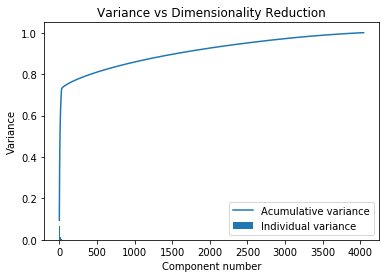

In [139]:
plt.plot(variances.Component, variances.acumulative_variance);
plt.bar(variances.Component, variances.variance);
plt.xlabel('Component number') 
plt.ylabel('Variance');
plt.legend(['Acumulative variance','Individual variance']);
plt.title('Variance vs Dimensionality Reduction');

In [140]:
variances.head()

,Component,variance,acumulative_variance
0,1.0,0.094321,0.094321
1,2.0,0.089018,0.183339
2,3.0,0.068295,0.251634
3,4.0,0.052640,0.304275
4,5.0,0.042735,0.347010


We´ve decided to keep the 95% of the variability in the original data, so we are going to reduce the dataframe to 2268 dimensions (the initial variables where 4047)

In [143]:
for i in range(len(variances)):
    if variances.acumulative_variance[i] > 0.70:
        num = i
        var = variances.acumulative_variance[i]
        break
        
print("Amazing!!! using", i, "variables, we can explain", round(var,2), "of the variability in the original data.")

Amazing!!! using 25 variables, we can explain 0.7 of the variability in the original data.


In [144]:
for i in range(len(variances)):
    if variances.acumulative_variance[i] > 0.95:
        num = i
        var = variances.acumulative_variance[i]
        break
        
print("Amazing!!! using", i, "variables, we can explain", round(var,2), "of the variability in the original data.")

Amazing!!! using 2483 variables, we can explain 0.95 of the variability in the original data.


In [6]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 2483)
movies_pca = pca.fit_transform(movies2)

In [7]:
movies_pca_end = pd.DataFrame(movies_pca)
movies_pca_end.head()

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
0,0.168129,-0.345323,0.062517,-0.371511,0.645595,0.762352,0.220971,-0.346820,-0.240426,-0.054568,...,0.002450,0.001902,-0.004659,-0.000209,-0.003078,0.000358,-0.005402,-0.000020,0.003028,0.000918
1,0.207597,-0.163752,0.406542,-0.316053,0.350565,0.127545,-0.397599,-0.176429,-0.520157,-0.088410,...,0.001450,0.001694,-0.003637,0.000108,-0.003093,0.000253,-0.004592,-0.000276,0.002670,0.001347
2,-0.700549,-0.228507,0.117995,-0.454304,-0.176023,-0.393428,0.105952,-0.547478,-0.537655,0.177528,...,0.001813,0.002132,-0.003389,0.000095,-0.001958,0.000300,-0.004986,-0.000759,0.002677,0.000320
3,-0.594042,-0.239867,-0.044477,-0.355494,0.157157,-0.090054,-0.313220,-0.105201,-0.019812,-0.120168,...,-0.008286,0.000422,0.002536,-0.002879,0.006158,-0.001271,0.004795,-0.001921,-0.000826,0.002077
4,-0.625740,-0.222838,-0.043250,-0.359005,0.154169,-0.059038,-0.379108,-0.094800,-0.091116,-0.125937,...,-0.007872,0.001261,0.002867,-0.002611,0.006460,-0.001236,0.004778,-0.002098,-0.001223,0.002501


#### Interpreting Principal Components

Now that we have our transformed principal components, we are going to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [12]:
def pc_indexes(df, pca, n):
    """
    Gives the 10 most important variables with its weights in the component n after applying pca to de dataframe df
    
    INPUT: df (dataframe), pca (transformation applied), n(principal component to analyze)
    OUTPUT: list of the top 10 variables and their weights
    """

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions
    df_comp = components.iloc[n-1].to_frame()
    df_comp["Abs_value"] = df_comp.abs()
    df_comp = df_comp.sort_values(by='Abs_value', ascending = False)
    df_comp = df_comp[df_comp.columns[0]].head(10)
    return df_comp


In [13]:
# Get weights for the first principal component
pc_indexes(movies2, pca, 1)

genre_Drama       -0.7814
genre_Comedy       0.5923
genre_Horror       0.0830
dec__2010          0.0771
genre_Crime       -0.0767
genre_Adventure    0.0685
dec__2000         -0.0617
genre_Action       0.0342
genre_Family       0.0327
genre_Animation    0.0312
Name: Dimension 1, dtype: float64

In [14]:
pc_indexes(movies2, pca, 2)

dec__2010         0.8190
dec__2000        -0.4132
genre_Comedy     -0.2248
Year              0.1713
genre_Thriller    0.1330
genre_Romance    -0.1264
dec__1990        -0.1070
genre_Horror      0.0985
dec__1980        -0.0694
dec__1970        -0.0572
Name: Dimension 2, dtype: float64

In [15]:
pc_indexes(movies2, pca, 3)

genre_Comedy      -0.5572
genre_Drama       -0.4227
genre_Thriller     0.3293
genre_Romance     -0.3202
genre_Action       0.3012
genre_Horror       0.2568
dec__2010         -0.2475
genre_Crime        0.1630
dec__2000          0.1217
genre_Adventure    0.1193
Name: Dimension 3, dtype: float64

In [16]:
pc_indexes(movies2, pca, 4)

dec__2000       0.7898
dec__1990      -0.3155
Year            0.2690
dec__2010       0.2308
dec__1980      -0.1778
dec__1970      -0.1527
genre_Action   -0.1220
dec__1960      -0.1166
genre_Crime    -0.1066
genre_Horror    0.1036
Name: Dimension 4, dtype: float64

We can see that the first 4 principal components are based on the genre and when it was filmed (different decades or year)

#### Merging dataframes

In [17]:
movies_pca_end

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
0,0.168129,-0.345323,0.062517,-0.371511,0.645595,0.762352,0.220971,-0.346820,-0.240426,-0.054568,...,-0.004058,0.005748,-0.005993,0.008009,0.002085,-0.000799,0.000849,-0.002787,0.001638,-0.000891
1,0.207597,-0.163752,0.406542,-0.316053,0.350565,0.127545,-0.397599,-0.176429,-0.520157,-0.088410,...,-0.003100,0.005912,-0.005610,0.006938,0.002890,0.000023,0.000383,-0.004167,0.001639,-0.001179
2,-0.700549,-0.228507,0.117995,-0.454304,-0.176023,-0.393428,0.105952,-0.547478,-0.537655,0.177528,...,-0.003646,0.004458,-0.004730,0.006728,0.002148,-0.000896,0.000968,-0.002250,0.001675,-0.000657
3,-0.594042,-0.239867,-0.044477,-0.355494,0.157157,-0.090054,-0.313220,-0.105201,-0.019812,-0.120168,...,-0.005313,-0.001068,-0.000525,-0.001203,-0.001697,-0.004882,0.003776,-0.001363,-0.007272,-0.009340
4,-0.625740,-0.222838,-0.043250,-0.359005,0.154169,-0.059038,-0.379108,-0.094800,-0.091116,-0.125937,...,-0.005543,-0.001649,-0.000486,-0.000839,-0.001935,-0.005499,0.003850,-0.000242,-0.006973,-0.008734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89256,0.089904,0.503382,-0.878954,0.128585,-0.256828,-0.363566,-0.089455,0.071255,0.190171,-0.045676,...,0.000204,-0.000143,-0.000086,-0.000014,-0.000338,-0.000231,-0.000111,0.000683,-0.000093,0.000353
89257,0.795537,-0.274034,-0.206664,-0.088156,0.018171,-0.236888,-0.113521,0.014559,-0.013721,-0.069512,...,-0.008706,0.036063,0.019582,0.022632,0.031797,-0.024108,-0.016120,-0.013052,0.006357,-0.000817
89258,0.014044,-0.316054,-0.628250,-0.102159,-0.146665,-0.414411,-0.137713,0.084698,0.236957,-0.073760,...,0.017567,-0.001438,0.001119,-0.010389,-0.003994,0.005090,0.011706,0.007306,-0.005876,0.005610
89259,-0.502569,0.728286,-0.322372,0.112387,-0.039259,-0.050236,-0.191868,0.061087,-0.039485,0.016329,...,0.000156,-0.000219,-0.000008,-0.000113,-0.000544,-0.000414,0.000128,0.000946,0.000088,0.000332


In [18]:
movies1

,averageRating
0,0.544444
1,0.466667
2,0.566667
3,0.544444
4,0.466667
...,...
89256,0.655556
89257,0.444444
89258,0.755556
89259,0.777778


In [8]:
df_movies = pd.merge(movies1, movies_pca_end, left_index=True, right_index=True)

In [9]:
df_movies.head()

,averageRating,0,1,2,3,4,5,6,7,8,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
0,0.544444,0.168129,-0.345323,0.062517,-0.371511,0.645595,0.762352,0.220971,-0.346820,-0.240426,...,0.002450,0.001902,-0.004659,-0.000209,-0.003078,0.000358,-0.005402,-0.000020,0.003028,0.000918
1,0.466667,0.207597,-0.163752,0.406542,-0.316053,0.350565,0.127545,-0.397599,-0.176429,-0.520157,...,0.001450,0.001694,-0.003637,0.000108,-0.003093,0.000253,-0.004592,-0.000276,0.002670,0.001347
2,0.566667,-0.700549,-0.228507,0.117995,-0.454304,-0.176023,-0.393428,0.105952,-0.547478,-0.537655,...,0.001813,0.002132,-0.003389,0.000095,-0.001958,0.000300,-0.004986,-0.000759,0.002677,0.000320
3,0.544444,-0.594042,-0.239867,-0.044477,-0.355494,0.157157,-0.090054,-0.313220,-0.105201,-0.019812,...,-0.008286,0.000422,0.002536,-0.002879,0.006158,-0.001271,0.004795,-0.001921,-0.000826,0.002077
4,0.466667,-0.625740,-0.222838,-0.043250,-0.359005,0.154169,-0.059038,-0.379108,-0.094800,-0.091116,...,-0.007872,0.001261,0.002867,-0.002611,0.006460,-0.001236,0.004778,-0.002098,-0.001223,0.002501


### <a class="anchor" id="Alg_Selection"> 3.b.- Algorithm Selection
We´re going to test a few regression algorithms with all the features and the default parameters to see which one works better

In [31]:
X = df_movies.drop("averageRating", axis=1).copy()
y = df_movies["averageRating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((71408, 2483), (71408,), (17853, 2483), (17853,))

In [11]:
#function to test the algorithm
def test_model(alg):
    train_score = 0
    test_score = 0
    clf = alg
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test) 
    
    return train_score, test_score

In [24]:
#Test Linear Regression, create df of scores and its score
model = test_model(LinearRegression())
scores = pd.DataFrame({'Algorithm': 'Linear Regression', 'Train_score': [model[0]], 'Test_score': [model[1]]},columns = ['Algorithm','Train_score','Test_score'])

In [28]:
#Test Lasso, create add score to df
model =test_model(Lasso())
scores = scores.append({'Algorithm' : 'Lasso' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [30]:
#Test Elastic Net, create add score to df
model =test_model(ElasticNet())
scores = scores.append({'Algorithm' : 'Elastic Net' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)


In [32]:
#Test KNeighborsRegressor(), create add score to df
model =test_model(KNeighborsRegressor())
scores = scores.append({'Algorithm' :'KNeighbors Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [34]:
#Test DecisionTreeRegressor(), create add score to df
model =test_model(DecisionTreeRegressor())
scores = scores.append({'Algorithm' : 'Decision Tree Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [36]:
#Test GradientBoostingRegressor(), create add score to df
model =test_model(GradientBoostingRegressor())
scores = scores.append({'Algorithm' : 'Gradient Boosting Regressor' , 'Train_score' : model[0], 'Test_score' : model[1]} , ignore_index=True)

In [38]:
print("The score of the different algorithms is")
scores.sort_values(by ='Test_score', ascending = True)

The score of the different algorithms is


,Algorithm,Train_score,Test_score
4,Decision Tree Regressor,0.999538,-0.284863
1,Lasso,0.000000,-0.000027
2,Elastic Net,0.000000,-0.000027
3,KNeighbors Regressor,0.519938,0.267497
0,Linear Regression,0.445800,0.412906
5,Gradient Boosting Regressor,0.434244,0.412957


We are using R2 score:

- There are negative values in test score. This is because because the model can be arbitrarily worse, and it´s not a good model for this case (Decision Tree, Lasso and Elastic Net)

- Look at the Decision Tree...thats overfitting!!!! Almost one in train and negative in test.

- The two best are Linear Regression and Gradient Boosting Regressor, with similar results, around 0.4 score

This is a really poor prediction, telling us that is very difficult to predict wether or not people is going to like a movie or not. The next step should be tuning with parameters but it has not much sense with these poor results, because we could get some little higher score but always uacceptable

What we are going to do in other notebooks is narrow the number of movies for different cases and see if in those cases the predictions can be better.